In [1]:
import numpy as np
import sys
import os
sys.path.append(os.pardir)
from dataset.mnist import load_mnist
from common.functions import *
# from common.gradient import numerical_gradient
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt

In [2]:
def numerical_gradient(f, x):
    h = 1e-4  # 0.0001
    grad = np.zeros_like(x)
    
    def compute_gradient(idx):
        tmp_val = x[idx]

        x[idx] = float(tmp_val) + h
        fxh1 = f(x)

        x[idx] = tmp_val - h
        fxh2 = f(x)

        grad[idx] = (fxh1 - fxh2) / (2*h)

        x[idx] = tmp_val
    
    with ThreadPoolExecutor() as executor:
        it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
        futures = [executor.submit(compute_gradient, it.multi_index) for _ in it]
        for future in futures:
            future.result()
        
    return grad

In [3]:
class TwoLayerNet:
    
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y

    def loss(self, x, t):
        y = self.predict(x)

        return cross_entropy_error(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])

        return grads

    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}

        batch_num = x.shape[0]

        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)

        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)

        da1 = np.dot(dy, W2.T)
        dz1 = sigmoid_grad(a1) * da1
        grads['W1'] = np.dot(x.T, dz1)
        grads['b1'] = np.sum(dz1, axis=0)

        return grads

In [4]:
(x_train, t_train), (x_test, t_test) = \
    load_mnist(normalize=True, one_hot_label=True)

In [5]:
iters_num = 10000 
train_size = x_train.shape[0]
batch_size = 600  
learning_rate = 0.1
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

In [6]:
train_loss_list = []
train_acc_list = []
test_acc_list = []
ilist = []

iter_per_epoch = max(train_size / batch_size, 1)
iter_per_epoch

100.0

In [7]:
for i in range(iters_num):

    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)  # 다음 장에서 구현할 더 빠른 방법!

    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]

    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_batch, t_batch)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))


train acc, test acc | 0.16166666666666665, 0.1349
train acc, test acc | 0.11166666666666666, 0.1136
train acc, test acc | 0.4, 0.4038
train acc, test acc | 0.49166666666666664, 0.5001
train acc, test acc | 0.65, 0.6811
train acc, test acc | 0.7216666666666667, 0.7496
train acc, test acc | 0.8116666666666666, 0.8036
train acc, test acc | 0.8, 0.827
train acc, test acc | 0.8433333333333334, 0.8448
train acc, test acc | 0.865, 0.8587
train acc, test acc | 0.855, 0.8673
train acc, test acc | 0.88, 0.8747
train acc, test acc | 0.87, 0.8823
train acc, test acc | 0.8866666666666667, 0.8881
train acc, test acc | 0.8916666666666667, 0.8916
train acc, test acc | 0.88, 0.8948
train acc, test acc | 0.9, 0.8969
train acc, test acc | 0.9016666666666666, 0.899
train acc, test acc | 0.89, 0.9018
train acc, test acc | 0.9066666666666666, 0.9038
train acc, test acc | 0.9133333333333333, 0.9043
train acc, test acc | 0.8983333333333333, 0.9069
train acc, test acc | 0.8883333333333333, 0.9088
train acc, te

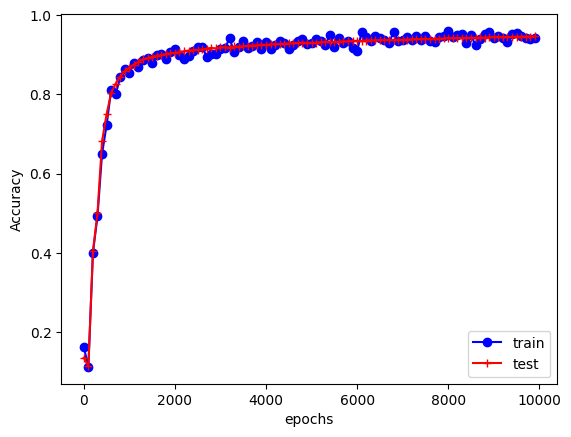

In [8]:
plt.plot(list(range(0,10000,100)), train_acc_list, marker='o', linestyle='-', color='blue', label='train')
plt.plot(list(range(0,10000,100)), test_acc_list, marker='+', linestyle='-', color='red', label='test')
plt.legend(loc='lower right')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.show()

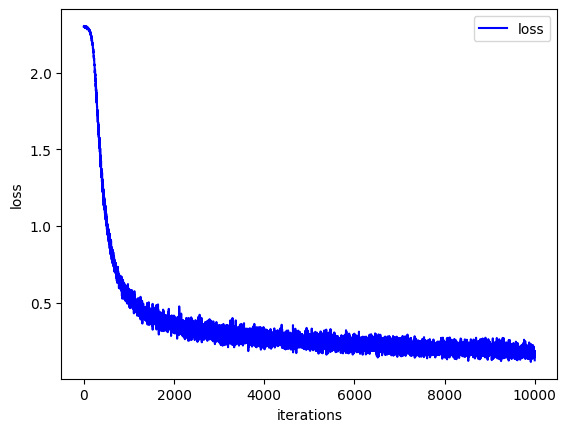

In [9]:

plt.plot(list(range(iters_num)), train_loss_list, linestyle='-', color='blue', label='loss')
plt.legend(loc='upper right')
plt.xlabel("iterations")
plt.ylabel("loss")
plt.show()

In [ ]:
iters_num = 10000 
train_size = x_train.shape[0]
batch_size = 600  
learning_rate = 0.1
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

train_loss_list = []
train_acc_list = []
test_acc_list = []
ilist = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):

    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grad = network.numerical_gradient(x_batch, t_batch)
    # grad = network.gradient(x_batch, t_batch) 

    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]

    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_batch, t_batch)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))


train acc, test acc | 0.11166666666666666, 0.0973


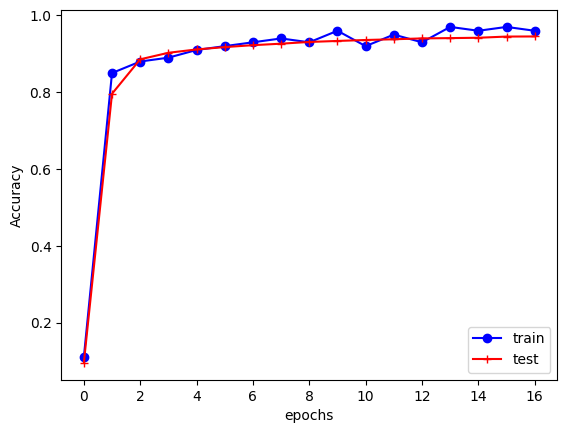

In [12]:
plt.plot(list(i//600 for i in range(0,10000,600)), train_acc_list, marker='o', linestyle='-', color='blue', label='train')
plt.plot(list(i//600 for i in range(0,10000,600)), test_acc_list, marker='+', linestyle='-', color='red', label='test')
plt.legend(loc='lower right')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.show()